<a href="https://colab.research.google.com/github/travis3630/Foundation-in-ML/blob/main/ML_lab2_Softmax_Regression_2a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import jax.numpy as jnp
from jax import grad
from jax import random

In [2]:
def softmax_prob_forloop(W, b, inputs): # output is datalen-by-C (NumPy, no JAX here)
    # inputs is dim-by-datalen
    # b is C-dimensional vector W is (C-by-dim)
    dim, datalen = np.shape(inputs) # how many dimensions, points
    c = len(b) # number of classes, C, each class has a bias 
    score = np.zeros((c, datalen))
    for ci in range(c):
        for lj in range(datalen):
            score[ci, lj] = b[ci]
            for dk in range(dim):
                score[ci, lj] += W[ci, dk]*inputs[dk, lj]
    maxes = np.zeros(datalen)
    for lj in range(datalen):
        maxes[lj] = np.max(score[:, lj])
    for ci in range(c):
        for lj in range(datalen):
            score[ci, lj] = score[ci, lj] - maxes[lj]
    # subtract off the largest score from the bias of each class 
    # This is for stability to underflow/overflow when exponentiating
    expscore = np.exp(score)
    norm_factor = np.diag(1/np.sum(expscore, axis=0))
    return np.dot(expscore, norm_factor).T  


# below we convert the same steps into vector form, hence no for loops

def softmax_prob1(W, b, inputs):  # output is datalen-by-C
    # inputs is dim-by-datalen
    # b is C-dimensional vector W is (C-by-dim)
    # Make sure all numerical operations are from JAX, so 'jnp', not 'np'
    datalen = jnp.shape(inputs)[1] # how many points
    c = len(b) # number of classes, C, each class has a bias 
    linear_part = jnp.dot(W, inputs) # (C-by-dim)*(dim-by-datalen) = C-by-datalen
    large = jnp.max(linear_part, axis=0) # largest of the class scores for each data point
    bias_offset = jnp.dot(jnp.diag(b),jnp.ones((c, datalen))) # (C-by-C)*(C-by-L)
    # subtract off the largest score from the bias of each class for stability to underflow/overflow
    large_offset = jnp.dot(np.ones((c, datalen)),jnp.diag(large)) #  (C-by-L)*(L-by-L)    
    expscore = jnp.exp(linear_part + bias_offset - large_offset)
    norm_factor = jnp.diag(1/jnp.sum(expscore, axis=0))
    return jnp.dot(expscore, norm_factor).T 

In [3]:
def softmax_prob(W, inputs):  
    # output is datalen-by-C
    # inputs is (dim)-by-datalen
    # W is C-by-(dim+1)
    # Make sure all numerical operations are from JAX, so 'jnp', not 'np'
    datalen = jnp.shape(inputs)[1] # how many points
    c = len(W) # number of classes, C, each class has a bias
    inputs = jnp.concatenate((jnp.ones((1,datalen)), inputs), axis=0)
    # create inputs (dim+1)-by-datalen 
    score = jnp.dot(W,inputs) 
    # (C-by-(1+dim))*((1+dim)-by-datalen) = C-by-datalen
    large = jnp.max(score, axis=0) # largest of the class scores for each data point
    # subtract off the largest score from the bias of each class for stability to underflow/overflow
    large_offset = jnp.dot(np.ones((c, datalen)),jnp.diag(large)) #  (C-by-L)*(L-by-L)    
    expscore = jnp.exp(score  - large_offset)
    norm_factor = jnp.diag(1/jnp.sum(expscore, axis=0))
    return jnp.dot(expscore, norm_factor).T  

In [4]:
def softmax_xentropy(Wb, inputs, targets, num_classes):
    epsilon = 1e-8
    ys = get_one_hot(targets, num_classes)
    logprobs = -jnp.log(softmax_prob(Wb, inputs)+epsilon)
    return jnp.mean(ys*logprobs)

In [5]:
def get_one_hot(targets, num_classes):
    res = jnp.eye(num_classes)[jnp.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape)+[num_classes])

In [6]:
Wb = jnp.array([[-3., 1.3, 2.0, -1.0], [-6., -2., -3., 1.5], [1., 2.0, 2.0, 2.5], [3., 4.0, 4.0, -2.5]])
# Build a toy dataset: 6 3-dim points with C=4  targets dim-by-datalen
inputs = jnp.array([[0.52, 1.12,  0.77],
                    [3.82, -6.11, 3.15],
                   [0.88, -1.08, 0.15],
                   [0.52, 0.06, -1.30],
                   [0.74, -2.49, 1.39],
                   [0.14, -0.43, -1.69]]).T # transpose to make it a dim-by-datalen array
targets = jnp.array([0, 1, 3, 2, 1, 2])

/usr/local/lib/python3.6/dist-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [7]:
# Initialize random model coefficients
key = random.PRNGKey(0)
key, W_key= random.split(key, 2)
[classes, dim] = 4, 3
Winit = random.normal(W_key, (classes, dim+1))
print(Winit)

[[ 0.20820066 -1.0580499  -0.29374585 -0.44117254]
 [ 0.2366984  -0.03426386 -1.0025561   1.1560111 ]
 [-0.5381381  -0.48968917  0.24939033 -1.4128867 ]
 [ 1.8543106   0.22756499  0.49751544 -2.089685  ]]


In [8]:
def grad_descent(Wb, inputs, targets, num_classes,  lrate, nsteps):
    W1 = Wb
    Whist = [W1]
    losshist = [softmax_xentropy(W1,inputs, targets, num_classes )]
    eta = lrate # learning rate
    for i in range(nsteps):        
        gWb = grad(softmax_xentropy, (0))(W1, inputs, targets, num_classes)
        W1 = W1 - eta*gWb
        if (i%5 ==0):
            Whist.append(W1)
            losshist.append(softmax_xentropy(W1, inputs, targets, num_classes))
    Whist.append(W1)
    losshist.append(softmax_xentropy(W1, inputs, targets, num_classes))    
    return W1, Whist, losshist

In [9]:
W2, Whist, losshist = grad_descent(Winit, inputs, targets, 4, 0.75, 200)


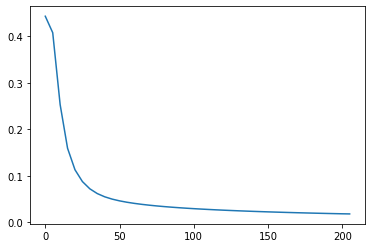

In [10]:
plt.plot([5*i for i in range(len(losshist))], losshist)

In [11]:
print('From:\n',np.around(softmax_prob(Winit, inputs),3))
print('To:\n',np.around(softmax_prob(W2, inputs),3))
print('Target:\n',get_one_hot(targets, 4))

From:
 [[0.09  0.243 0.05  0.618]
 [0.    1.    0.    0.   ]
 [0.073 0.507 0.028 0.392]
 [0.011 0.002 0.025 0.962]
 [0.008 0.99  0.    0.002]
 [0.013 0.001 0.028 0.957]]
To:
 [[0.951 0.009 0.006 0.034]
 [0.    0.996 0.    0.004]
 [0.025 0.13  0.043 0.802]
 [0.004 0.    0.949 0.047]
 [0.001 0.926 0.    0.074]
 [0.    0.    0.979 0.021]]
Target:
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]]


In [12]:
######## You code goes here ########
input1 = np.random.normal(0, 2,(6, 5))

target1 = jnp.array([0, 1, 3, 6, 2])
print(input)
print(targets)

<bound method Kernel.raw_input of <google.colab._kernel.Kernel object at 0x7f7aad3ed630>>
[0 1 3 2 1 2]


In [13]:
# Initialize random model coefficients
key = random.PRNGKey(3)
key, W_key= random.split(key, 2)
[classes, dim] = 5, 6
Winit1 = random.normal(W_key, (classes, dim+1))
print(Winit1)

[[-0.686968    0.773368    0.49174884 -0.6715969  -0.03117218  2.3585725
  -0.08030237]
 [ 1.0044307   0.42849985  0.25236854 -0.5371668  -1.2999266   0.42621404
  -0.6013335 ]
 [ 0.64366454 -0.09016193 -0.11567771  0.32708928  1.7033087   0.93371433
  -0.5723629 ]
 [ 0.47008014  1.190262    0.12222908  0.28468987 -0.31269106  0.32497638
  -0.35595027]
 [ 0.3049843   0.07506692  1.34496     0.6725463   0.04175337  0.3846813
  -1.0970293 ]]


In [14]:
W3, Whist3, losshist3 = grad_descent(Winit1, input1, target1, 5, 2.0, 200)
W4, Whist4, losshist4 = grad_descent(Winit1, input1, target1, 5, 0.5, 300)

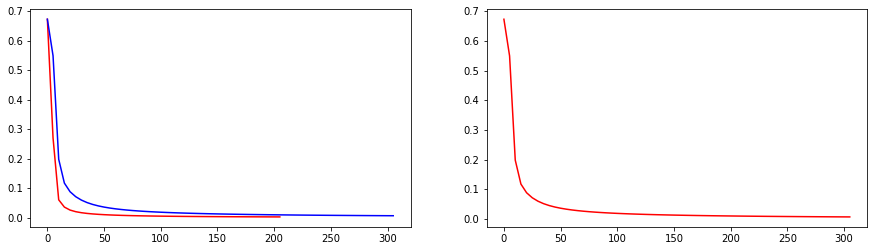

In [22]:
fig, ax = plt.subplots(figsize=(15,4), nrows=1, ncols=2)
ax[0].plot([5*i for i in range(len(losshist3))], losshist3, c='r')
ax[0].plot([5*i for i in range(len(losshist4))], losshist4, c='b')
ax[1].plot([5*i for i in range(len(losshist4))], losshist4, c='r')